### 1. Laboratorio clase 5: Introducción y contexto

En este laboratorio recorreremos todo el arco conceptual que conecta la atención con los Transformers autoregresivos que hoy dominan NLP. Los objetivos de este laboratorio son los siguiente:

1. Visualizar cómo se calculan los pesos de atención y cómo se interpretan
2. Implementar paso a paso Multi-Head Attention y un bloque Transformer mínimo en PyTorch
3. Entrenar un mini-modelo de lenguaje en español y generar texto
4. Comparar con un modelo GPT-2 preentrenado, destacando ventajas y límites

### 2. Atención y su visualización


Partimos de un ejemplo numérico mínimo para calcular manualmente los pesos de atención con dot-product escalado. Adicionalmente, dibujamos un mapa de calor (heat-map) y vemos intuitivamente cómo se reparten las probabilidades entre las diferentes keys.  

In [1]:
# Importamos librerías necesarias

import numpy as np
import matplotlib.pyplot as plt

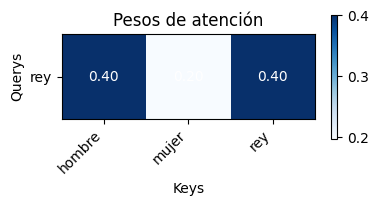

Resultado de la atención (context vector): [[20.]]


In [2]:
# Ponemos palabras en vectores arbitrarios. Además calculamos y visualizamos atención

queries = ["rey"]
words    = ["hombre", "mujer", "rey"]

q = np.array([[1.0, 0.0]])                    
k = np.array([[1.0, 0.0],                      
              [0.0, 1.0],                      
              [1.0, 1.0]])                     
v = np.array([[10], [20], [30]])               

def attention(query, key, value):
    """
    Calcula la atención escalar entre un query y un conjunto de keys y values.

    Args:
        query (np.ndarray): Vector de consulta (query).
        key (np.ndarray): Matriz de claves (keys).
        value (np.ndarray): Matriz de valores (values).

    Returns:
        tuple: (vector de contexto resultante, matriz de pesos de atención)
    """
    d_k = query.shape[-1]
    scores = np.dot(query, key.T) / np.sqrt(d_k)
    weights = np.exp(scores) / np.sum(np.exp(scores), axis=-1, keepdims=True)
    attended = np.dot(weights, value)
    return attended, weights

result, weights = attention(q, k, v) 

fig, ax = plt.subplots(figsize=(4,2))
im = ax.imshow(weights, cmap="Blues")

ax.set_xticks(np.arange(len(words)))
ax.set_xticklabels(words, rotation=45, ha="right")
ax.set_yticks(np.arange(len(queries)))
ax.set_yticklabels(queries)

for i in range(weights.shape[1]):
    ax.text(i, 0, f"{weights[0,i]:.2f}", ha="center", va="center", color="white")

ax.set_title("Pesos de atención")
ax.set_xlabel("Keys")
ax.set_ylabel("Querys")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print("Resultado de la atención (context vector):", result)


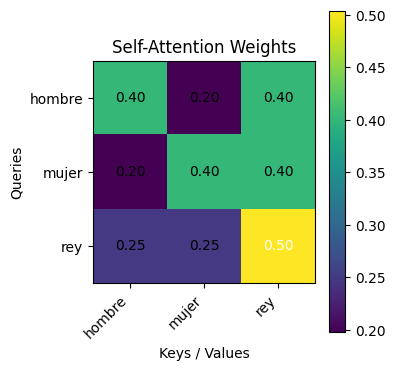

Context vectors shape: (3, 2)
Context matrix (cada fila es el nuevo embedding):
 [[0.802 0.599]
 [0.599 0.802]
 [0.752 0.752]]


In [3]:
# Ponemos palabras en vectores arbitrarios. Además calculamos y visualizamos auto-atención

X = np.array([
    [1.0, 0.0],   # "rey"
    [0.0, 1.0],   # "hombre"
    [1.0, 1.0],   # "mujer"
])  

def self_attention(X):
    """
    Calcula la auto-atención sobre una matriz de embeddings.

    Args:
        X (np.ndarray): Matriz de embeddings de entrada.

    Returns:
        tuple: (matriz de embeddings atendidos, matriz de pesos de atención)
    """
    d_k = X.shape[-1]
    scores = X.dot(X.T) / np.sqrt(d_k)
    exp = np.exp(scores)
    weights = exp / exp.sum(axis=1, keepdims=True)
    attended = weights.dot(X)
    return attended, weights

attended, W = self_attention(X)

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(W, cmap="viridis")

ax.set_xticks(np.arange(len(words)))
ax.set_xticklabels(words, rotation=45, ha="right")
ax.set_yticks(np.arange(len(words)))
ax.set_yticklabels(words)

for i in range(len(words)):
    for j in range(len(words)):
        ax.text(j, i, f"{W[i,j]:.2f}", ha="center", va="center",
                color="white" if W[i,j]>0.5 else "black")

ax.set_title("Self-Attention Weights")
ax.set_xlabel("Keys / Values")
ax.set_ylabel("Queries")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print("Context vectors shape:", attended.shape)
print("Context matrix (cada fila es el nuevo embedding):\n", np.round(attended,3))


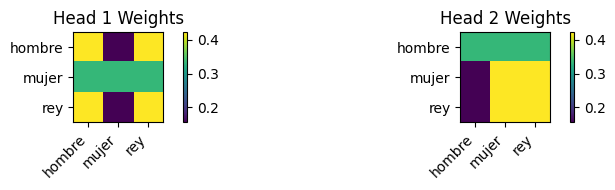

Output concatenado de ambas cabezas:
 [[0.8446376  0.66666667]
 [0.66666667 0.8446376 ]
 [0.8446376  0.8446376 ]]


In [4]:
# Ponemos palabras en vectores arbitrarios. Además calculamos y visualizamos atención con múltiples cabezas

def multi_head_attention(X, num_heads=2):
    """
    Calcula la atención multi-cabeza sobre una matriz de embeddings.

    Args:
        X (np.ndarray): Matriz de embeddings de entrada.
        num_heads (int): Número de cabezas de atención.

    Returns:
        tuple: (matriz de salida concatenada, lista de matrices de pesos de atención por cabeza)
    """
    B, d_model = X.shape
    assert d_model % num_heads == 0
    d_k = d_model // num_heads

    head_outputs = []
    head_weights = []
    for h in range(num_heads):
        Q = X[:, h*d_k:(h+1)*d_k]
        K = Q.copy()
        V = Q.copy()

        scores = Q.dot(K.T) / np.sqrt(d_k)
        exp_scores = np.exp(scores)
        weights = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        attended = weights.dot(V)

        head_outputs.append(attended)
        head_weights.append(weights)

    output = np.concatenate(head_outputs, axis=1)
    return output, head_weights

output, weights_list = multi_head_attention(X, num_heads=2)

fig, axes = plt.subplots(1, 2, figsize=(8,2))
for i, ax in enumerate(axes):
    im = ax.imshow(weights_list[i], cmap="viridis")
    ax.set_xticks(np.arange(len(words)))
    ax.set_xticklabels(words, rotation=45, ha="right")
    ax.set_yticks(np.arange(len(words)))
    ax.set_yticklabels(words)
    ax.set_title(f"Head {i+1} Weights")
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print("Output concatenado de ambas cabezas:\n", output)


### 3. Jugando con un transformador de jugete

Esta sección implementa:  

* **`MultiHeadAttention`** (varias cabezas paralelas)
* **`TransformerBlock`**  (attention + feed-forward + layer-norm) 
* Un pequeño modelo autoregresivo entrenado en un corpus español reducido

Al finalizar entrenamos unas pocas épocas y llamamos a `sample_toy` para generar texto. Tambiíen revisa hiperparámetros (`context_len`, `d_model`,`num_heads`) si queremos mayor coherencia.

In [5]:
# Importamos librerías necesarias

import torch
import torch.nn.functional as F
import torch.nn as nn

In [6]:
# Definimos clases para la atención multi-cabeza, el bloque Transformer

class MultiHeadAttention(nn.Module):
    """
    Implementa la atención multi-cabeza para modelos tipo Transformer.

    Args:
        d_model (int): Dimensión del modelo.
        num_heads (int): Número de cabezas de atención.
    """
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        """
        Realiza la pasada hacia adelante de la atención multi-cabeza.

        Args:
            x (torch.Tensor): Tensor de entrada de forma (batch, secuencia, d_model).

        Returns:
            tuple: (tensor de salida, pesos de atención)
        """
        B, T, C = x.size()
        Q = self.W_q(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.d_k**0.5
        weights = F.softmax(scores, dim=-1)
        heads = torch.matmul(weights, V)
        concat = heads.transpose(1, 2).contiguous().view(B, T, C)
        return self.W_o(concat), weights
    
class TransformerBlock(nn.Module):
    """
    Implementa un bloque Transformer compuesto por atención multi-cabeza y red feed-forward.

    Args:
        d_model (int): Dimensión del modelo.
        num_heads (int): Número de cabezas de atención.
        ff_hidden_dim (int): Dimensión oculta de la red feed-forward.
    """
    def __init__(self, d_model, num_heads, ff_hidden_dim):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        """
        Realiza la pasada hacia adelante del bloque Transformer.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Returns:
            torch.Tensor: Tensor de salida.
        """
        x = self.norm1(x + self.attn(x)[0])
        x = self.norm2(x + self.ff(x))
        return x

In [7]:
# Calculamos el vector de contexto

encoder_outputs = torch.rand(1, 4, 16)
decoder_hidden = torch.rand(1, 1, 16)

scores = torch.matmul(decoder_hidden, encoder_outputs.transpose(-2, -1)) / np.sqrt(16)
weights = F.softmax(scores, dim=-1)
context = torch.matmul(weights, encoder_outputs)


In [8]:
# Definimos corpus y procesamos el texto

corpus = [
    "el sol brilla en el cielo azul durante el día",
    "la luna ilumina suavemente la noche estrellada",
    "los modelos de lenguaje procesan texto y generan contenido",
    "los transformers revolucionaron el procesamiento de lenguaje natural",
    "me gusta estudiar redes neuronales y algoritmos de aprendizaje",
    "la inteligencia artificial transforma múltiples industrias",
    "los datos son fundamentales para entrenar buenos modelos",
    "los estudiantes aprenden mejor con ejemplos prácticos",
    "las redes neuronales convolucionales se usan en visión por computador",
    "la generación de texto es una tarea del modelado de lenguaje",
    "las computadoras procesan información de manera eficiente",
    "la programación es una habilidad muy útil hoy en día",
    "los algoritmos permiten resolver problemas complejos",
    "la ciencia de datos combina estadística y computación",
    "muchos dispositivos modernos incorporan inteligencia artificial",
    "los asistentes virtuales utilizan modelos de lenguaje",
    "el aprendizaje profundo permite representaciones jerárquicas",
    "el análisis de texto incluye tareas como clasificación y resumen",
    "las redes recurrentes fueron predecesoras de los transformers",
    "el preentrenamiento mejora el rendimiento de los modelos",
    "las máquinas entienden patrones complejos mediante entrenamiento supervisado",
    "los corpus extensos ayudan a mejorar la generalización de los modelos",
    "los investigadores experimentan con arquitecturas neuronales avanzadas",
    "el lenguaje humano es complejo y contextual",
    "las técnicas de atención mejoran la comprensión semántica"
] * 10

vocab = sorted(list(set("".join(corpus))))
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(vocab)

def encode(text):
    """
    Codifica un texto a una lista de índices según el vocabulario.

    Args:
        text (str): Texto de entrada.

    Returns:
        list: Lista de índices correspondientes a los caracteres del texto.
    """
    return [stoi[c] for c in text]

def decode(indices):
    """
    Decodifica una lista de índices a una cadena de texto según el vocabulario.

    Args:
        indices (list): Lista de índices.

    Returns:
        str: Texto decodificado.
    """
    return "".join([itos.get(i, "?") for i in indices])

def create_dataset(corpus, context_len):
    """
    Crea un dataset de pares (entrada, objetivo) para modelado de lenguaje.

    Args:
        corpus (list): Lista de frases de texto.
        context_len (int): Longitud del contexto (ventana de entrada).

    Returns:
        tuple: (tensor X de entradas, tensor Y de objetivos)
    """
    X, Y = [], []
    for sentence in corpus:
        ids = encode(sentence)
        for i in range(len(ids) - context_len):
            X.append(ids[i:i+context_len])
            Y.append(ids[i+1:i+context_len+1])
    return torch.tensor(X), torch.tensor(Y)

context_len = 12
X, Y = create_dataset(corpus, context_len)

In [9]:
# Definimos clase para generar el modelo, lo generamos y lo entrenamos

class ToyTransformerLM(nn.Module):
    """
    Modelo Transformer de juguete para modelado de lenguaje a nivel de caracteres.

    Args:
        vocab_size (int): Tamaño del vocabulario.
        d_model (int): Dimensión del embedding y del modelo.
        num_heads (int): Número de cabezas de atención.
        ff_dim (int): Dimensión oculta de la red feed-forward.
    """
    def __init__(self, vocab_size, d_model, num_heads, ff_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos = nn.Parameter(torch.randn(1, context_len, d_model))
        self.block = TransformerBlock(d_model, num_heads, ff_dim)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        """
        Realiza la pasada hacia adelante del modelo Transformer.

        Args:
            x (torch.Tensor): Tensor de entrada de forma (batch, secuencia).

        Returns:
            torch.Tensor: Logits de salida para cada posición de la secuencia.
        """
        x = self.embedding(x) + self.pos
        x = self.block(x)
        return self.fc(x)

model = ToyTransformerLM(vocab_size, d_model=64, num_heads=4, ff_dim=128)
opt = torch.optim.Adam(model.parameters(), lr=0.003)
loss_fn = nn.CrossEntropyLoss()

for step in range(1000):
    i = torch.randint(0, X.size(0), (16,))
    x_batch, y_batch = X[i], Y[i]
    logits = model(x_batch)
    loss = loss_fn(logits.view(-1, vocab_size), y_batch.view(-1))
    opt.zero_grad()
    loss.backward()
    opt.step()
    if step % 100 == 0:
        print(f"Epoch {step}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 3.5224
Epoch 100, Loss: 0.1736
Epoch 200, Loss: 0.2268
Epoch 300, Loss: 0.1635
Epoch 400, Loss: 0.1162
Epoch 500, Loss: 0.1979
Epoch 600, Loss: 0.1178
Epoch 700, Loss: 0.1013
Epoch 800, Loss: 0.1220
Epoch 900, Loss: 0.1301


In [10]:
# Denifimos función para generar texto según prompts

def sample_toy(model, start, length):
    """
    Genera texto carácter por carácter usando un modelo Transformer de juguete.

    Args:
        model (nn.Module): Modelo entrenado.
        start (str): Prompt de inicio.
        length (int): Número de caracteres a generar.

    Returns:
        str: Texto generado.
    """
    model.eval()
    ids = encode(start)[-context_len:]
    ids = [0] * (context_len - len(ids)) + ids
    input_seq = torch.tensor(ids).unsqueeze(0)
    for _ in range(length):
        with torch.no_grad():
            logits = model(input_seq)
            if hasattr(logits, "logits"):
                logits = logits.logits
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1).item()
            input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[next_id]])], dim=1)
    return decode(input_seq[0].tolist())

prompt = "el sol br"
print("Prompt:", prompt)
print("Completado (modelo de juguete):", sample_toy(model, prompt, 200))


Prompt: el sol br
Completado (modelo de juguete): onsuraronese


### 4. Modelos pre-entrenados


Mostramos cómo usar GPT-2 pequeño en español (`datificate/gpt2-small-spanish`) para completar prompts sin re-entrenar. Sirve para contrastar el rendimiento de un modelo masivo frente a nuestro Transformer casero y justificar el pre-entrenamiento auto-supervisado.

In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "datificate/gpt2-small-spanish"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

prompt = "La inteligencia artificial es"
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(
    inputs["input_ids"],
    max_length=100,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.9,
    pad_token_id=tokenizer.eos_token_id
)
print("Texto generado:", tokenizer.decode(outputs[0], skip_special_tokens=True))

/Users/fdiazja/nlp_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/fdiazja/nlp_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Texto generado: La inteligencia artificial es un campo que estudia la función de la información y las propiedades del cerebro. Los métodos de inteligencia artificial de la inteligencia artificial de la inteligencia artificial pueden ser desarrollados en el mismo campo. Los métodos de inteligencia artificial de la inteligencia artificial de la inteligencia artificial de la inteligencia artificial de la inteligencia artificial de la inteligencia artificial de la inteligencia artificial de la inteligencia artificial de la inteligencia artificial de la inteligencia artificial de la inteligencia artificial de la inteligencia artificial de la inteligencia artificial de la inteligencia artificial de la inteligencia
